In [ ]:
%pip install pynwb

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pynwb import NWBFile, TimeSeries, NWBHDF5IO

In [5]:
from aind_dynamic_foraging_models.logistic_regression.model import prepare_logistic_design_matrix

### Get example data

Assuming you're in Code Ocean and the data asset `foraging_nwb_bonsai` is attached.

In [6]:
session_name = '/root/capsule/data/foraging_nwb_bonsai/703548_2024-03-20_10-47-42.nwb'


In [ ]:
io = NWBHDF5IO(session_name, mode='r')
nwb = io.read()

In [8]:
df_trial = nwb.trials.to_dataframe()
df_trial[['animal_response', 'rewarded_historyL', 'rewarded_historyR']].head(10)

,animal_response,rewarded_historyL,rewarded_historyR
id,,,
0,1.0,False,False
1,1.0,False,True
2,1.0,False,True
3,1.0,False,False
4,1.0,False,False
5,1.0,False,False
6,1.0,False,False
7,1.0,False,True
8,0.0,True,False


### Get design matrix

In [9]:
# Turn to 0 and 1 coding (assuming all trials are non-autowater trials)
choice_history = df_trial['animal_response'].values
choice_history[choice_history == 2] = np.nan
reward_history = ((df_trial['rewarded_historyL'] == True) + (df_trial['rewarded_historyR'] == True)).astype(int).values

In [12]:
df_design = prepare_logistic_design_matrix(choice_history, 
                                      reward_history, 
                                      logistic_model='Hattori2019', 
                                      n_trial_back=15)
df_design.head()

X                                                               \
      RewC_15 RewC_14 RewC_13 RewC_12 RewC_11 RewC_10 RewC_9 RewC_8 RewC_7   
trial                                                                        
15        0.0     1.0     1.0     0.0     0.0     0.0    0.0    1.0   -1.0   
16        1.0     1.0     0.0     0.0     0.0     0.0    1.0   -1.0   -0.0   
17        1.0     0.0     0.0     0.0     0.0     1.0   -1.0   -0.0   -1.0   
18        0.0     0.0     0.0     0.0     1.0    -1.0   -0.0   -1.0   -1.0   
19        0.0     0.0     0.0     1.0    -1.0    -0.0   -1.0   -1.0   -0.0   

              ...                                                        \
      RewC_6  ... Choice_9 Choice_8 Choice_7 Choice_6 Choice_5 Choice_4   
trial         ...                                                         
15      -0.0  ...      1.0      1.0     -1.0     -1.0     -1.0     -1.0   
16      -1.0  ...      1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
17      -1.0  ...     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
18      -0.0  ...     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
19      -1.0  ...     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

                                      Y  
      Choice_3 Choice_2 Choice_1 Choice  
trial                                    
15        -1.0     -1.0     -1.0   -1.0  
16        -1.0     -1.0     -1.0   -1.0  
17        -1.0     -1.0     -1.0   -1.0  
18        -1.0     -1.0     -1.0   -1.0  
19        -1.0     -1.0     -1.0   -1.0  

[5 rows x 46 columns]

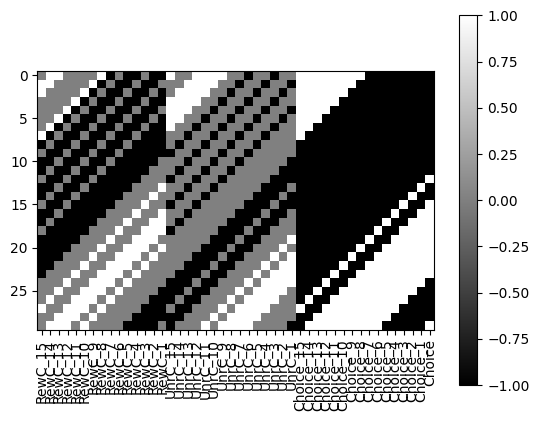

In [20]:
Y = df_design.Y.to_numpy()
X = df_design.X.to_numpy()
trials, var_names = df_design.index, df_design.X.columns

fig, ax = plt.subplots(1,1)
im = ax.imshow(np.concatenate([X[:30,:], Y[:30]], axis=1), cmap='gray')
ax.set_xticks(range(len(var_names) + 1))
ax.set_xticklabels(var_names.to_list() + ['Choice'], rotation=90)
fig.colorbar(im)
plt.show()

### Do one fitting

In [19]:
from aind_dynamic_foraging_models.logistic_regression.model import fit_logistic_regression

In [20]:
result = fit_logistic_regression(choice_history, reward_history)

In [14]:
result.keys()

dict_keys(['model', 'model_terms', 'n_trial_back', 'df_design', 'df_beta', 'logistic_reg_cv', 'beta_bootstrap'])

In [15]:
result['df_beta'].RewC_1

,RewC_1
cross_validation,1.049212
bootstrap_mean,1.108382
bootstrap_std,0.159246
bootstrap_CI_lower,0.801201
bootstrap_CI_upper,1.433476


In [16]:
result['n_trial_back']

15

In [18]:
fit = result['logistic_reg_cv']

In [25]:
result['X'].shape

(458, 30)